In [50]:
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple
from tqdm import tqdm
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [29]:
if torch.cuda.is_available():
    _device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Используется GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA не доступна, используется CPU')
    _device = torch.device("cpu")

CUDA не доступна, используется CPU


In [30]:
# загрузим токенизатор и классификатор
_model_name = 'bert-base-uncased'
_tokenizer = BertTokenizer.from_pretrained(_model_name, do_lower_case=True)
_model = BertForSequenceClassification.from_pretrained(_model_name, num_labels=2, output_attentions=False, output_hidden_states=False)

if torch.cuda.is_available():
    _model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
_train_val_df = pd.read_csv("./data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
_test_df = pd.read_csv("./data/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

_train_val_documents = _train_val_df.sentence.values[:10] #TODO
_train_val_labels = _train_val_df.label.values[:10]

_train_documents, _val_documents, _train_labels, _val_labels = train_test_split(_train_val_documents, _train_val_labels, test_size=0.1)

_test_documents = _test_df.sentence.values[:10] #TODO
_test_labels = _test_df.label.values[:10]

Применим токенайзер к одному предложению и посмотрим, что получится.


In [73]:
def tokenize_documents(documents, tokenizer):
    input_ids = []
    attention_masks = []

    for document in documents:
        result = tokenizer.encode_plus(document,
                                       add_special_tokens=True,
                                       max_length=64,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_tensors='pt',
                                       #truncation=True
                                      )

        input_ids.append(result['input_ids'])
        attention_masks.append(result['attention_mask'])

    # возвращаем результат ввиде тензоров
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# токенизируем документы
_train_input_ids, _train_attention_masks = tokenize_documents(_train_documents, _tokenizer)
_train_labels = torch.tensor(_train_labels)

_val_input_ids, _val_attention_masks = tokenize_documents(_val_documents, _tokenizer)
_val_labels = torch.tensor(_val_labels)

_test_input_ids, _test_attention_masks = tokenize_documents(_test_documents, _tokenizer)
_test_labels = torch.tensor(_test_labels)

C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [74]:
def create_dataloader(input_ids, attention_masks, labels):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    sampler = RandomSampler(dataset)
    return DataLoader(dataset, sampler=sampler, batch_size=32)

_train_dataloader = create_dataloader(_train_input_ids, _train_attention_masks, _train_labels)
_validation_dataloader = create_dataloader(_val_input_ids, _val_attention_masks, _val_labels)
_test_dataloader = create_dataloader(_test_input_ids, _test_attention_masks, _test_labels)

10 10 10


Обучим модель.

In [82]:
def train(model, train_dataloader, validation_dataloader):
    n_epochs = 4
    optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * n_epochs)

    training_stats = []

    for epoch in range(0, n_epochs):
        print(f'Эпоха {epoch} / {n_epochs}')

        total_train_loss = 0

        model.train() # переводим модель в режим обучения

        for _, batch in tqdm(enumerate(train_dataloader)):
            b_input_ids = batch[0].to(_device)
            b_input_mask = batch[1].to(_device)
            b_labels = batch[2].to(_device)

            model.zero_grad() # обнуляем градиенты

            resonse = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

            loss = resonse['loss']

            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        print('Валидация...')

        avg_val_loss, _ = test(model, validation_dataloader)
    
        training_stats.append(
            {
                'epoch': epoch + 1,
                'training_loss': avg_train_loss,
                'validation_loss': avg_val_loss
            }
        )

    plot_learning_curve(training_stats)

def test(model, dataloader):
    model.eval() # переводим модель в режим предсказания

    total_eval_accuracy = 0
    total_eval_loss = 0

    all_logits = []
    all_labels = []

    for batch in dataloader:
        b_input_ids = batch[0].to(_device)
        b_input_mask = batch[1].to(_device)
        b_labels = batch[2].to(_device)

        with torch.no_grad():
            response = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = response['loss']
        logits = response['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        all_logits.append(logits)
        all_labels.append(label_ids)

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    data_len = len(dataloader)
    avg_val_accuracy = total_eval_accuracy / data_len
    avg_val_loss = total_eval_loss / data_len

    print(f"AVG Accuracy: {avg_val_accuracy}")
    print(f"Validation Loss: {avg_val_loss}")

    print_accuracy(all_logits, all_labels)
    print_mcc(all_logits, all_labels)

    return avg_val_loss, avg_val_accuracy

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def print_accuracy(preds, labels):
    pred_flat = np.concatenate(preds, axis=0)
    pred_flat = np.argmax(pred_flat, axis=1).flatten()
    labels_flat = np.concatenate(labels, axis=0)
    print(pred_flat, labels_flat)
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    print(f'Accuracy: {accuracy}')

def print_mcc(preds, labels):
    matthews_set = []

    for i in range(len(labels)):
        pred_labels_i = np.argmax(preds[i], axis=1).flatten()
    
        # Calculate and store the coef for this batch.
        matthews = matthews_corrcoef(labels[i], pred_labels_i)
        matthews_set.append(matthews)
  
    # Combine the results across all batches.
    flat_predictions = np.concatenate(preds, axis=0)
    
    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    
    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(labels, axis=0)
    
    # Calculate the MCC
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
    
    print(f'MCC: {mcc}')

def plot_learning_curve(training_stats):
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['training_loss'], 'b-o', label="Training")
    plt.plot(df_stats['validation_loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()

C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Эпоха 0 / 4


1it [00:02,  2.52s/it]
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Валидация...
AVG Accuracy: 1.0
Validation Loss: 0.1970689743757248
[1] [1]
Accuracy: 1.0
MCC: 0.0
Эпоха 1 / 4


1it [00:02,  2.09s/it]
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Валидация...
AVG Accuracy: 1.0
Validation Loss: 0.17144903540611267
[1] [1]
Accuracy: 1.0
MCC: 0.0
Эпоха 2 / 4


1it [00:02,  2.32s/it]
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Валидация...
AVG Accuracy: 1.0
Validation Loss: 0.1522231101989746
[1] [1]
Accuracy: 1.0
MCC: 0.0
Эпоха 3 / 4


1it [00:02,  2.60s/it]
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Vasilij\home\projects\git\otus\nlp\otus-nlp-homeworks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Валидация...
AVG Accuracy: 1.0
Validation Loss: 0.14443941414356232
[1] [1]
Accuracy: 1.0
MCC: 0.0


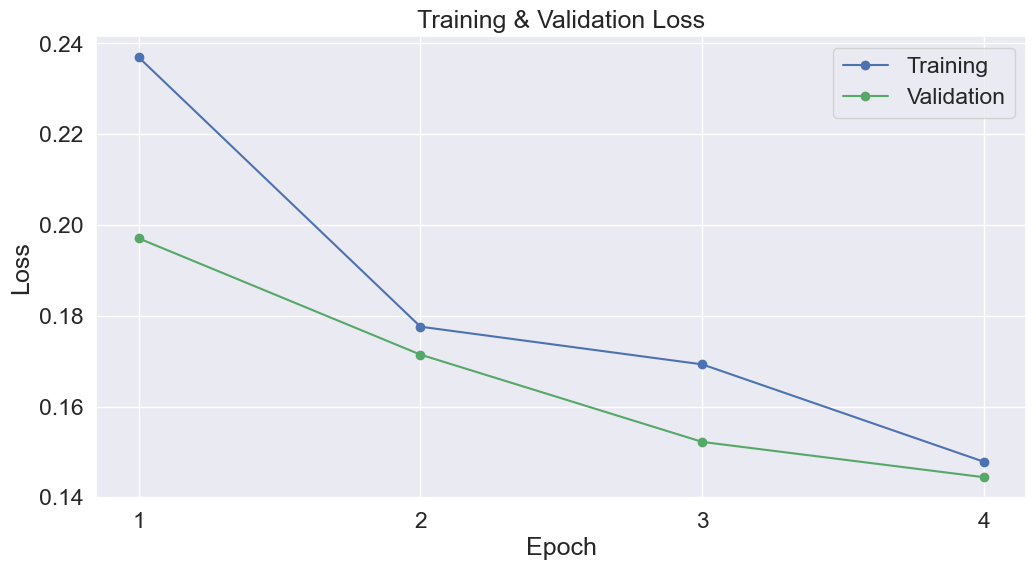

In [84]:
train(_model, _train_dataloader, _validation_dataloader)

## 5.2. Оценка на тесте


In [83]:
test(_model, _test_dataloader)

AVG Accuracy: 0.8
Validation Loss: 0.523719310760498
[1 1 1 1 1 1 1 1 1 1] [1 1 0 1 1 1 1 1 0 1]
Accuracy: 0.8
MCC: 0.0


(0.523719310760498, np.float64(0.8))